# Image Classification for Cats and Dogs (CNN)
![title](https://cdn-images-1.medium.com/max/1600/1*NQQiyYqJJj4PSYAeWvxutg.png)

#### The goal of this project is to create a model that can classify a set of new images as cats or dogs

#### Image classification is the task of taking an input image and outputting a class or a probability of classes that best describles the image

#### A Convolution Neural Network (CNN) is a deep learning algorithm which can take in an input image,assign importance to various aspects in the image and be able to differentiate one from the other.



## 1. Setting 

### 1.1 Import Libraries

In [1]:
import numpy as np #array operations
import matplotlib.pyplot as plt #show image 
import os  #directories and join paths
import cv2 #image operations
import random #random generator
import pickle #use for saving object
import time #record time
#deep learning:CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

%matplotlib inline

### 1.2 Import Image and Data-Preprocessing
- Change the Image to GrayScale.Since RGB data is three times the size of grayscale data and color is not the differentiating factor between cats and dogs
- Normalization : normalized image shape to the given size

Original Image: 


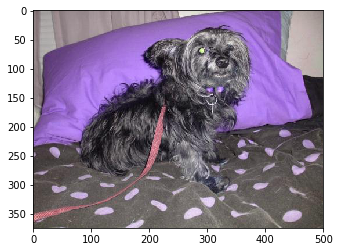

Processed Image: 


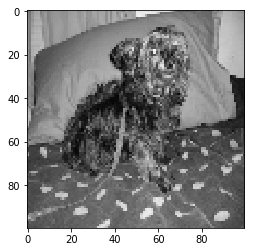

In [45]:
DATADIR="C:/Datasets/PetImages"
def Preprocessing(image,size):
    """
    Change the Original Image array to the standard form
    Input:
        image: a original image array 
        size: integer, normalize each image to this given size
    Return:
        new_image_array: a transformed Image array
    """
    new_image=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #RGB is 3 times larger than GrayScale
    new_image=cv2.resize(new_image,(size,size)) #normalize every image shape
    
    return new_image
    
#Show the original image
path=os.path.join(DATADIR,"DOG","0.jpg") #Dog image 0
img_array=cv2.imread(path)  #read the original image array 
print ("Original Image: ")
plt.imshow(img_array)
plt.show()

#Try to transform the image 
new_array=Preprocessing(img_array,100)
print ("Processed Image: ")
plt.imshow(new_array,cmap="gray")
plt.show()

### Import and preproceessing all the photo, save the image array with the label to an array
Class Label:
- Dogs:0
- Cats:1

In [46]:
training_data=[]
CATEGORIES=["DOG","CAT"]
IMG_SIZE=100

for category in CATEGORIES:
    path=os.path.join(DATADIR,category) 
    class_num=CATEGORIES.index(category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        try:
            new_array=Preprocessing(img_array,IMG_SIZE) 
            training_data.append([new_array,class_num]) #new_array:image array class_num:label
        #throw the problem image away
        except Exception as e:
            pass


In [52]:
print ("No.of Image:",len(training_data))

No.of Image: 24946


### Shuffle the data 
Ensure the model will be trained with Dogs and Cats randomly instead of trained with all the Dogs Data then trained with all the Cats Data

In [53]:
#shuffle the data 
random.shuffle(training_data)

### Split the data into features(X) and labels(y)
As we cannot pass a list to neural network, we have to convert the feature list to a numpy array before passing it to the neural network

In [57]:
X=[]
y=[]
for features, label in training_data:
    X.append(features)
    y.append(label)
X=np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,1) # convert the list to numpy array 

### Normalization: scale the data 
The value range of imagery data [0,255], divide all pixel by 255 to ensure each data value is between 0 to 1

In [58]:
#Normalizing data
X=X/255.0

### Save the dataset to pickle file
We can save the dataset to pickle file and recall it next time so that we don't have to rebuild the dataset everytime

In [59]:
#save the data 
pickle_out=open("X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out=open("y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

In [60]:
#recall the data
pickle_in=open("X.pickle","rb")
X=pickle.load(pickle_in)
pickle_in=open("y.pickle","rb")
y=pickle.load(pickle_in)

## 2. Build Model

### 2.1 Convolution Layer
The convolutional layer is the core building block of a CNN, Convolution preserves the relationship between pixels by learning image features using small squares of input data. 

The operation is to convolute the original image with a specific Feature Detector (or Filter matrix). Several kinds of Feature Detector will be randomly gernerated. With the feature detector , the boundary of the object will be extracted.
![title](https://cdn-images-1.medium.com/max/800/1*Klv6ebMkjVmAEP4XkMxTXQ.png)

### 2.2 Activation Function: Rectified Linear Unit (Relu)
Activation Function is a function that used to get the ouptut of node. It maps the resulting values in a given range (depends on the function type)

Range of Relu: [0 to infinity]
By using the Relu function to remove negative values, the boundary of the object will be more obvious
![title](https://cdn-images-1.medium.com/max/800/1*BZqw3CWuvtc7sNVjgcBPQg.png)

### 2.3 Pooling Layer (Max Pooling)

The Pooling layer is responsible for reducing the spatial size of the feature map.So the computational power required to process the data through dimensionality reduction can be decreased.

Max Pooling:The new pooled feature map is created by picking out the maximum value in the sample matrix. 

The main advantage of Max Pooling is that when the image is translated by a few Pixels, it will not affect the judgment. And it have good anti-noise function.
![title](https://cdn-images-1.medium.com/max/800/1*CGwpxQT5kJho3CbDZy2Qkw.png)


### 2.4 Fully Connected Layer (Dense, Flatten)
In a fully connected layer, we flatten the output of the last convolution layer and connect every node of the current layer with the other node of the next layer.

![title](https://cdn-images-1.medium.com/max/800/1*nzZGTF1yypBAQVRVFgvXAA.png)

### 2.5 Activation Function: Sigmoid
The Sigmoid Function curve looks like a S-shape.

Range of Sigmoid: [0,1]

Since probability of anything exists only between the range of 0 and 1, it is especially used for models where we have to predict the probability as an output.

![](https://cdn-images-1.medium.com/max/1200/1*8SJcWjxz8j7YtY6K-DWxKw.png)

### 2.6 Fit the model 
Epochs:One Epoch is when an entire dataset is passed forward and backward through the neural network only once.Since one epoch is too big to feed to the computer at once we have to divide it in several smaller batches

Passing the entire dataset through a neural network once is not enough. We need to pass the full dataset multiple times to the same neural network in order to have a better accuracy

Batch_size:Total number of training examples present in a single batch. As we can't pass the entire dataset into the neural network at once, we have to divide the dataset into number of batches.

validation_split: Percentage of the dataset used for testing.


In [62]:
#parameters
dense_layer=0
layer_size=64
conv_layer=3 

In [65]:
def CNNModel(dense_layer,layer_size,conv_layer):
    NAME="{}-conv-{}-nodes-{}-dense-{}".format(conv_layer,layer_size,dense_layer,int(time.time())) #Name of the TensorFlow graph
    tensorboard=TensorBoard(log_dir='logs/{}'.format(NAME)) # USing TensorBoard to visualize the TensorFlow graph

    model=Sequential()
    #first layer: Convolution Layer
    model.add(Conv2D(layer_size,(3,3),input_shape=X.shape[1:]))  #input variables: (layer_size, window_size,shape of the data)
    model.add(Activation("relu")) #relu function
    model.add(MaxPooling2D(pool_size=(2,2))) #pooling layer
    
    #More Connvolution Layer
    for l in range(conv_layer-1):
        model.add(Conv2D(layer_size,(3,3)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten()) #convert 2D feature maps to 1D feature vectors
    for l in range(dense_layer):               
        model.add(Dense(layer_size))
        model.add(Activation("relu"))

    model.add(Dense(1))
    model.add(Activation("sigmoid"))

    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
    model.fit(X,y,batch_size=32,epochs=3,validation_split=0.3,callbacks=[tensorboard])
    
    return model,tensorboard

In [66]:
model1,tensorboard1=CNNModel(dense_layer,layer_size,conv_layer)

Train on 17462 samples, validate on 7484 samples
Epoch 1/3
17462/17462 [==============================] - 2433s 139ms/step - loss: 0.6295 - acc: 0.6294 - val_loss: 0.5504 - val_acc: 0.7250
Epoch 2/3
17462/17462 [==============================] - 2501s 143ms/step - loss: 0.5147 - acc: 0.7474 - val_loss: 0.4799 - val_acc: 0.7728
Epoch 3/3
17462/17462 [==============================] - 2655s 152ms/step - loss: 0.4503 - acc: 0.7910 - val_loss: 0.4573 - val_acc: 0.7871


In [68]:
#save the model for future use
model1.save('64x3-CNN.model')

## 3. Optimize the model
- Fitting different parameters into the model
- Using TensorBoard to check with the validaiton loss of each model.
- The optimize model should have with least validaiton loss.


In [ ]:
#try to optimize the model
dense_layers=[0,1,2]
layer_sizes=[32,64,128]
conv_layers=[1,2,3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            CNNModel(dense_layer,layer_size,conv_layer)

By trying all the combinations of different parameters, the best model:
- dense_layer=0
- layer_size=64
- conv_layer =3

## 4. Predict New Image

In [124]:
model=tf.keras.models.load_model("64x3-CNN.model") #load the fitted model

In [125]:
#predict new photo with the model
def prepare(filepath):
    """
    convert the image to standard form for prediction
    Input:
        filepath: image path
    Return:
        image array
    """
    IMG_SIZE=100
    img_array=cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
    new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
    plt.imshow(new_array,cmap="gray")
    plt.show()
    return new_array.reshape(-1,IMG_SIZE,IMG_SIZE,1)



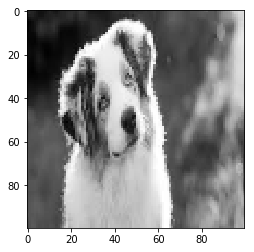

Prediction:  DOG
****************


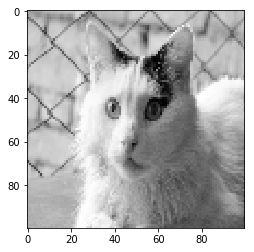

Prediction:  CAT
****************


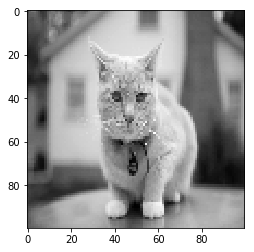

Prediction:  CAT
****************


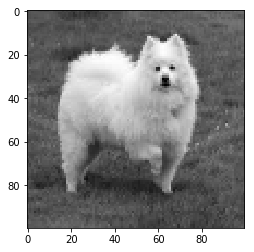

Prediction:  DOG
****************


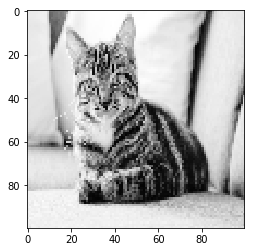

Prediction:  CAT
****************


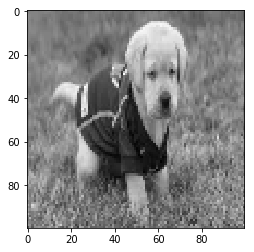

Prediction:  DOG
****************


In [127]:
testing_data=[]
IMG_SIZE=100
TESTDIR="C:/Datasets/TestImages"

for img in os.listdir(TESTDIR):
    prediction=model.predict(prepare(os.path.join(TESTDIR,img)))
    print ("Prediction: ",CATEGORIES[int(prediction[0][0])])
    print ("****************")    